In [14]:
import ast 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy import stats

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/covid_19_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

#clean
df.columns = df.columns.str.replace(' ', '_')
df['Last_Update'] = pd.to_datetime(df['Last_Update'], format='mixed') 
df['ObservationDate']= pd.to_datetime(df['ObservationDate'])

df.set_index('SNo', inplace=True)

df['Country/Region']= df['Country/Region'].fillna('else')
df['Province/State']= df['Province/State'].fillna('Unknown')

df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].clip(lower=0) 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306429 entries, 1 to 306429
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ObservationDate  306429 non-null  datetime64[ns]
 1   Province/State   306429 non-null  object        
 2   Country/Region   306429 non-null  object        
 3   Last_Update      306429 non-null  datetime64[ns]
 4   Confirmed        306429 non-null  float64       
 5   Deaths           306429 non-null  float64       
 6   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 18.7+ MB


In [16]:
df_US= df[df['Country/Region'] == 'US']
df_US

,ObservationDate,Province/State,Country/Region,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
32,2020-01-22,Washington,US,2020-01-22 17:00:00,1.0,0.0,0.0
72,2020-01-23,Washington,US,2020-01-23 17:00:00,1.0,0.0,0.0
122,2020-01-24,Washington,US,2020-01-24 17:00:00,1.0,0.0,0.0
123,2020-01-24,Chicago,US,2020-01-24 17:00:00,1.0,0.0,0.0
165,2020-01-25,Washington,US,2020-01-25 17:00:00,1.0,0.0,0.0
...,...,...,...,...,...,...,...
306396,2021-05-29,Virginia,US,2021-05-30 04:20:55,675165.0,11160.0,0.0
306406,2021-05-29,Washington,US,2021-05-30 04:20:55,435849.0,5765.0,0.0
306409,2021-05-29,West Virginia,US,2021-05-30 04:20:55,161287.0,2792.0,0.0


In [17]:
df_grouped = df_US.groupby(['Province/State', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].max().reset_index()

us_daily = df_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

us_daily

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-22,1.0,0.0,0.0
1,2020-01-23,1.0,0.0,0.0
2,2020-01-24,2.0,0.0,0.0
3,2020-01-25,2.0,0.0,0.0
4,2020-01-26,5.0,0.0,0.0
...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0
490,2021-05-26,33190470.0,591950.0,0.0
491,2021-05-27,33217995.0,593288.0,0.0
492,2021-05-28,33239963.0,593963.0,0.0


In [18]:
us_daily['New_Confirmed'] = us_daily['Confirmed'].diff()
us_daily['New_Deaths'] = us_daily['Deaths'].diff()

us_daily['GrowthRate_Confirmed'] = us_daily['Confirmed'].pct_change() * 100
us_daily['GrowthRate_Deaths'] = us_daily['Deaths'].pct_change() * 100

us_daily= us_daily.fillna(0)
us_daily

,ObservationDate,Confirmed,Deaths,Recovered,New_Confirmed,New_Deaths,GrowthRate_Confirmed,GrowthRate_Deaths
0,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,2020-01-23,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2020-01-24,2.0,0.0,0.0,1.0,0.0,100.000000,0.000000
3,2020-01-25,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2020-01-26,5.0,0.0,0.0,3.0,0.0,150.000000,0.000000
...,...,...,...,...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0,22756.0,621.0,0.068659,0.105197
490,2021-05-26,33190470.0,591950.0,0.0,24052.0,1009.0,0.072519,0.170745
491,2021-05-27,33217995.0,593288.0,0.0,27525.0,1338.0,0.082930,0.226033
492,2021-05-28,33239963.0,593963.0,0.0,21968.0,675.0,0.066133,0.113773


In [19]:
# Suppose you split your data into two periods
wave1 = us_daily.loc[us_daily['ObservationDate'] < '2020-07-01', 'GrowthRate_Confirmed']
wave2 = us_daily.loc[us_daily['ObservationDate'] >= '2020-07-01', 'GrowthRate_Confirmed']

t_stat, p_val = stats.ttest_ind(wave1.dropna(), wave2.dropna())
print("t-statistic:", t_stat)
print("p-value:", p_val)


t-statistic: 8.890159693221538
p-value: 1.1594266862150047e-17


In [20]:
corr, p = stats.pearsonr(us_daily['Confirmed'], us_daily['Deaths'])
print("Correlation:", corr)
print("p-value:", p)


Correlation: 0.9882045777281312
p-value: 0.0


In [21]:
import statsmodels.api as sm

X = sm.add_constant(us_daily['Confirmed'])
y = us_daily['Deaths']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 2.049e+04
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:38:08   Log-Likelihood:                -5795.9
No. Observations:                 494   AIC:                         1.160e+04
Df Residuals:                     492   BIC:                         1.160e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.073e+04   1943.383     26.105      0.0

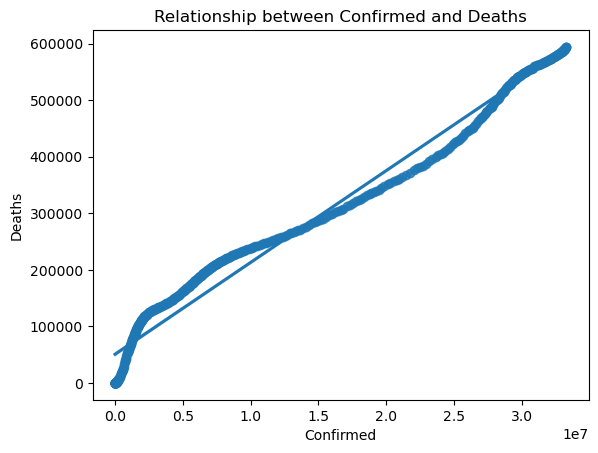

In [22]:
sns.regplot(x='Confirmed', y='Deaths', data=us_daily)
plt.title("Relationship between Confirmed and Deaths")
plt.show()
